<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/clusters/01_cluster_customer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kneed

In [2]:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from kneed import KneeLocator

from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, BisectingKMeans

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import ExtraTreesClassifier

import warnings

# **Config**
---

In [3]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.simplefilter("ignore")
title_data = 'Clientes del centro comercial'
paleta = sns.color_palette("tab10").as_hex()

**Funciones**
---

In [4]:
def plot_select_params(best_score, best_x_param, scores, x_params, **kwards):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5))
  ax.plot(x_params, scores)
  ax.plot(best_x_param, best_score, marker='o', color='r')
  ax.axvline(x=best_x_param,  color='r')
  ax.set_title(kwards['title'])
  ax.set_xlabel(kwards['xlabel'])
  ax.set_ylabel(kwards['ylabel'])

def silhouette_select_cluster(model, clusters, data, **kwards):
  """Metodo silhouette"""
  range_n_clusters = range(clusters[0], clusters[1])
  valores_medios_silhouette = {}
  for k in range_n_clusters:
    model.n_clusters = k
    model.fit(data)
    y_predict = model.predict(data)
    silhouette_avg = silhouette_score(data, y_predict)
    valores_medios_silhouette[k] = silhouette_avg

  x = list(range_n_clusters)
  y = list(valores_medios_silhouette.values())
  kneedle = KneeLocator(x, y, S=1.0, curve="concave", direction="increasing")

  best_score = valores_medios_silhouette[kneedle.elbow]
  best_cluster = kneedle.elbow

  res_data = {
      'score': best_score,
      'cluster': best_cluster,
  }
  plot_select_params(best_score, best_cluster, y, range_n_clusters,
                        title = f'Evolución de media de los índices silhouette {kwards["name_model"]}',
                        ylabel = 'Media índices silhouette',
                        xlabel = 'Numero clusters')

  return best_cluster, best_score


def pie_circle(
    serie:pd.Series,
    paleta=None,
    figsize_x:int=7,
    figsize_y:int=7,
    fontsize=15,
    **kwards)->None:
  """Grafica un anillo"""
  paleta = paleta if paleta !=None else generate_colors()[0]
  values = serie.value_counts().sort_index()
  names = values.index
  size = values.values
  fig, ax = plt.subplots(figsize=(figsize_x, figsize_y))
  fig.suptitle(f'Diagrama de anillo {kwards["title"]}', fontsize=fontsize)
  my_circle = plt.Circle( (0,0), 0.7, color='white')
  plt.pie(
      size,
      labels=names,
      autopct="%0.1f %%",
      wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' },
      colors = paleta)
  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()


def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)


def visulization_silhouette(data, y_predict, name, colores):
  """Visualiza el coeficiente de silhouette"""
  silhouette_avg=silhouette_score(data, y_predict)
  sample_silhouette_values = silhouette_samples(data, y_predict)
  y_lower = 5
  fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
  n_clusters = np.unique(y_predict).shape[0]
  ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])
  for i in np.unique(y_predict):

    # Agregue las puntuaciones de silueta para muestras pertenecientes a
    # agrupe i, y ordénelos
    ith_cluster_silhouette_values = \
        sample_silhouette_values[y_predict == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    try:
      ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=colores[i], edgecolor=colores[i], alpha=0.7)
    except:
      pass
    # Etiquete las parcelas de silueta con sus números de grupo en el medio
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule el nuevo y_lower para la siguiente parcela
    y_lower = y_upper + 10  # 10 para las 0 muestras
  ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")
  plt.suptitle((f"Silhouette analysis for {name} clustering on sample data "
                  f"with n_clusters = {n_clusters}" ),
                 fontsize=14, fontweight='bold')


def componentes_principales(data:object,
                            min_explained_variance:int=0.85,
                            min_component:int=3,
                            **kwards)->tuple:
  """simple method of PCA, that return data transform"""
  final_comp = 0
  for comp in range(min_component, data.shape[1]):
    pca = PCA(n_components=comp, **kwards)
    pca.fit(data)
    comp_check = pca.explained_variance_ratio_
    final_comp = comp
    if comp_check.sum() >= min_explained_variance:
      break

  final_pca = PCA(n_components=final_comp, **kwards)
  final_pca.fit(data)
  data_df = final_pca.transform(data)
  info = "Using {} components, we can explain {}% of the variability\
  in the original data.".format(final_comp,comp_check.sum())

  return data_df, final_pca, info

---
**Lo peculiar de este conjunto de datos, es que al no estandarizar se obtiene un modelo que separa mejor los conjuntos de datos. O explica mejor el proceso. Se intentó con dos estandarizaciones y dos modelos, y si bien se obtenían modelos óptimos en métrica y distribución, la explicación del negocio no permitía una explicación entendible, puesto que normalmente tres segmentos eran muy similar.**
---

**Data**
---

In [5]:
url = 'https://gist.githubusercontent.com/pravalliyaram/5c05f43d2351249927b8a3f3cc3e5ecf/raw/8bd6144a87988213693754baaa13fb204933282d/Mall_Customers.csv'
data = pd.read_csv(url, dtype='str')

# **EDA**

In [6]:
data.shape

(200, 5)

In [7]:
data.dtypes

CustomerID                object
Gender                    object
Age                       object
Annual Income (k$)        object
Spending Score (1-100)    object
dtype: object

In [8]:
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

- No hay valores nulos

In [9]:
data['CustomerID'].duplicated().sum()

0

- No hay valores duplicados en los identificadores de los clientes

In [10]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [11]:
data[
    [
        'Age',
        'Annual Income (k$)',
        'Spending Score (1-100)'
    ]
] = data[
    [
        'Age',
        'Annual Income (k$)',
        'Spending Score (1-100)'
    ]
].astype('int64')

In [12]:
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [13]:
data.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.00,200.00,200.00
mean,38.85,60.56,50.20
std,13.97,26.26,25.82
min,18.00,15.00,1.00
25%,28.75,41.50,34.75
50%,36.00,61.50,50.00
75%,49.00,78.00,73.00
max,70.00,137.00,99.00


- La media de la edad es aproximadamente de 39 años
- Con una desviación de 14 años, una dispersión de los datos no tan significativa para la característica.
- El valor mínimo es de 18 años
- El 25% acumulan los adultos jóvenes y adolescentes (con edad a partir de los 18 años)
- A partir del 50% incluye el percentil previo y las personas cercanas a la mediana edad.
- En el  75% incluyen los percentiles anteriores, pero también están las personas de la mediana edad.
- Después del 75% se encuentran las personas de la tercera edad y en edad de jubilación.
- *Es una muestra donde la mayoría son personas jóvenes y en edad productiva.*

---

- No se puede dar una interpretación del Annual Income (k$) acorde a la realidad, ya que los datos no son reales, aunque tratan de ejemplificar el contexto

---

- El puntaje en promedio de gasto es de 50.2, con una desviación de aproximadamente de 26, una dispersión a tener en cuenta. Donde la calificación mínima es de uno y la máxima es de 99. En el primer Q1 se encuentran agrupados, aquellos clientes con las calificaciones más bajas; en el segundo Q2 están los registros del Q1, pero también los clientes con las calificaciones intermedias y malas; en el Q3 se encuentran los dos primeros Cantiles, pero también acumula clientes con mejores calificaciones; Los clientes superiores al Q3 son aquellos con las mejores calificaciones.



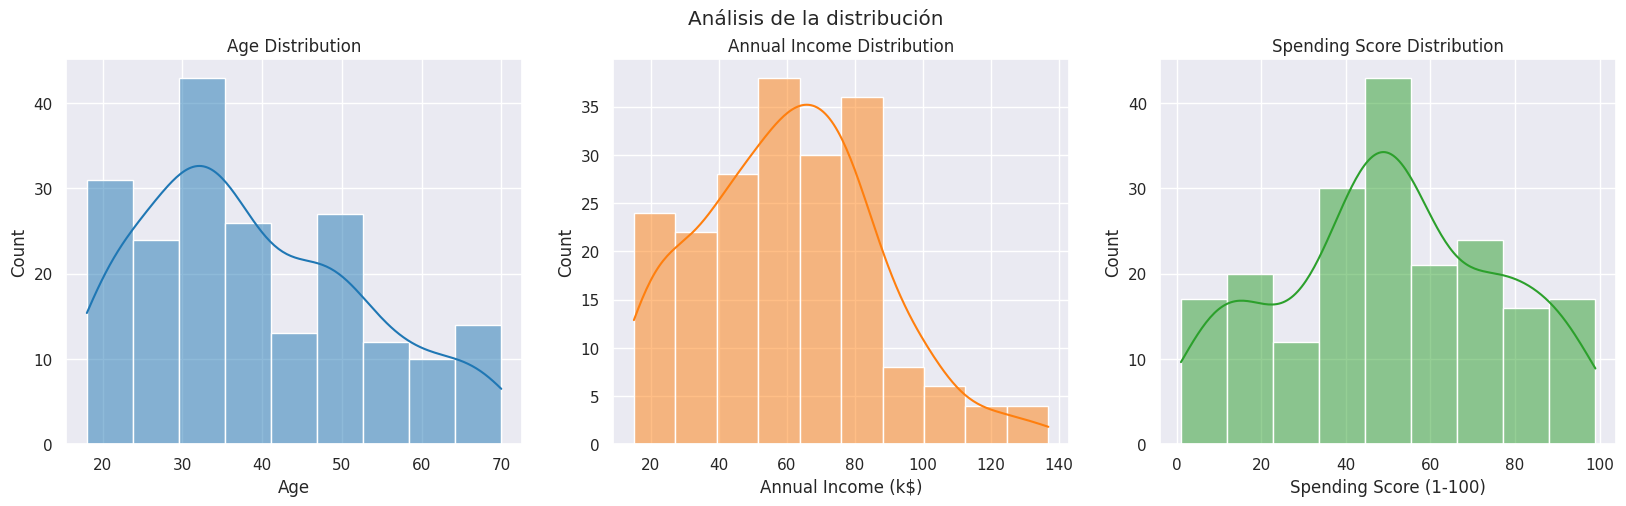

In [14]:
# Analizando la distribución densidad kerne
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=data, x='Age', kde=True, color=paleta[0], ax=ax[0])
sns.histplot(data=data, x='Annual Income (k$)', kde=True, color=paleta[1], ax=ax[1])
sns.histplot(data=data, x='Spending Score (1-100)', kde=True, color=paleta[2], ax=ax[2])

# Set the titles of the plots
ax[0].set_title('Age Distribution')
ax[1].set_title('Annual Income Distribution')
ax[2].set_title('Spending Score Distribution')

fig.suptitle('Análisis de la distribución')

plt.show()

- La base de clientes del centro comercial es en mayor medida de personas jóvenes y personas de la mediana edad, sobre todo en edad productiva. Tiene un sesgo hacia la izquierda en la edad, por lo tanto, la probabilidad de ocurrencia es predominantemente de personas jóvenes. Lo sugiere que las ofertas del centro comercial son particularmente atractivas para los jóvenes.

- La distribución en los ingresos no tiene un sesgo tan pronunciado hacia la izquierda, y tiene una forma cercana a la distribución normal, por lo tanto, se puede decir que los ingresos en mayor medida son ingresos medios a bajos, con una pequeña ocurrencia a ingresos altos. Lo anterior sugiere que los clientes podrían ser en su mayoría clase media y clase media baja.

- La distribución de la puntuación de gasto está centrada, lo que indica una data equilibrada de clientes de bajo y alto gasto. Esto sugiere que el centro comercial atrae a una amplia gama de clientes en términos de comportamiento de gasto.

In [15]:
data.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

In [16]:
X = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X_train = data[X]

In [17]:
#estimator = RobustScaler()
#estimator.fit(X_train)
#X_train = estimator.transform(X_train)

# **Model**
---

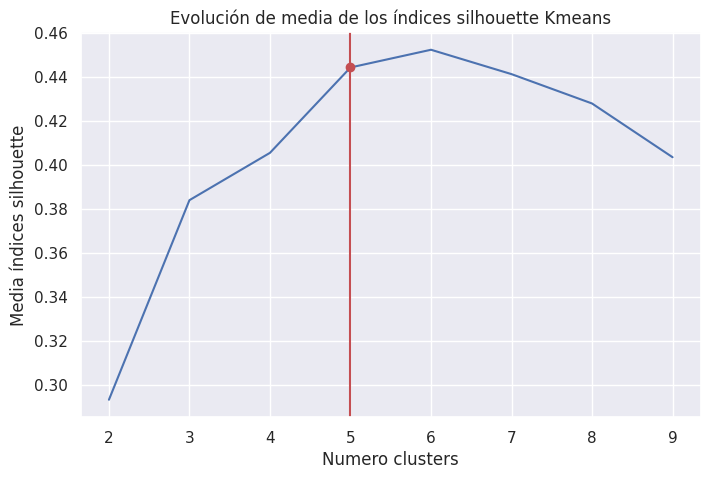

In [18]:
model = KMeans(
    init='k-means++',
    max_iter=300,
    random_state=12354,
    n_init=10)
silhouette_select_cluster(model, (2,10), X_train, name_model = 'Kmeans')
plt.show()

0.44428597560893024


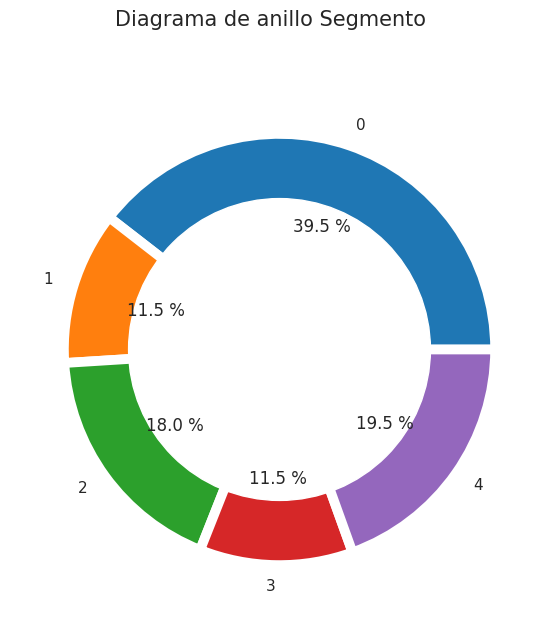

In [19]:
n_clusters = 5
model = KMeans(
    n_clusters = n_clusters,
    init='k-means++',
    max_iter=300,
    random_state=12354,
    n_init=10)

model.fit(X_train)
y_predict = model.predict(X_train)
score = silhouette_score(X_train, y_predict)
print(score)
pie_circle(pd.Series(y_predict), paleta=paleta, title='Segmento')

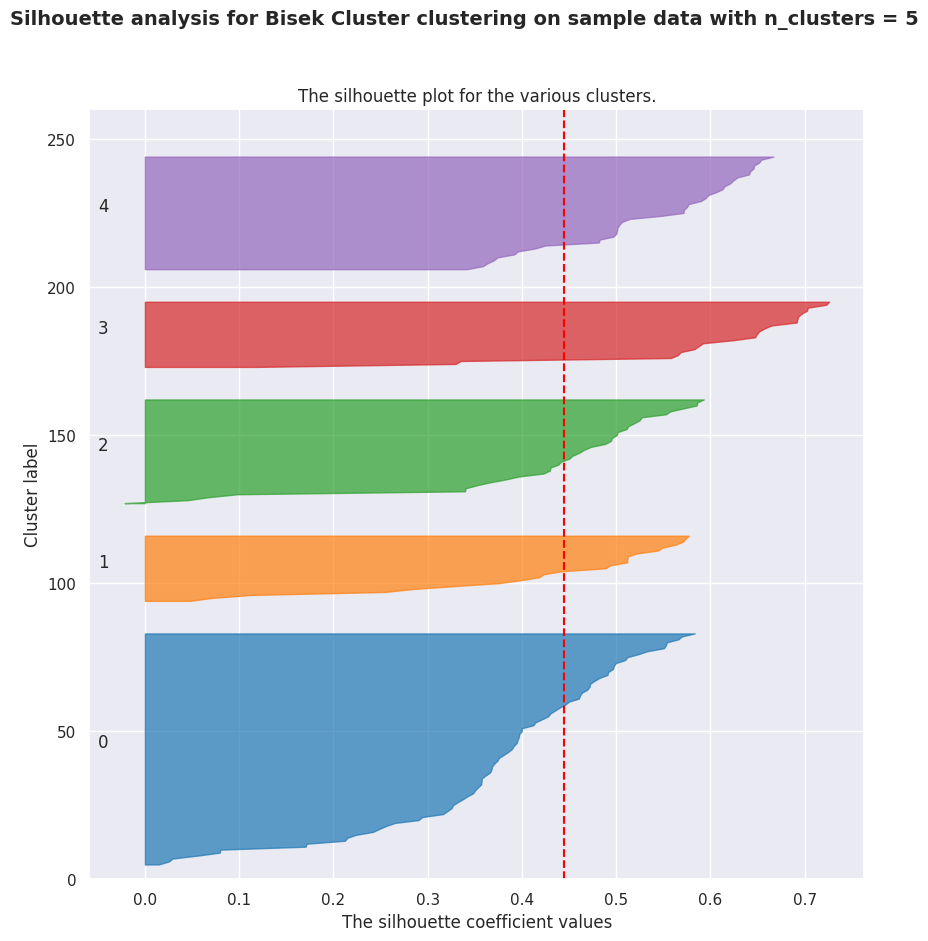

In [20]:
visulization_silhouette(
    X_train,
    y_predict,
    'Bisek Cluster',
    paleta)

La segmentación de cinco segmentos, tiene un promedio en el coeficiente de silueta de 0.44, donde el segmento tres es el más homogéneo. El segmento cero tiene más registros e internamente tiene diferentes niveles de homogénea por su forma más pronunciada en una de sus esquinas. El segmento 1 y 4 tiene una buena homogeneidad y heterogeneidad con el resto. El segmento tres tiene una buena agrupación, pero presenta una mínima porción de registros que quedarían mejor clasificados en otro conjunto.

In [21]:
data['segmento'] = y_predict

In [22]:
data_df, final_pca, info = componentes_principales(
    X_train,
    min_component=2,
    random_state = 12354
)

In [23]:
pdata = pd.concat([
    pd.DataFrame(data_df, columns = ['pc1', 'pc2']),
    data['segmento']
], axis = 1)

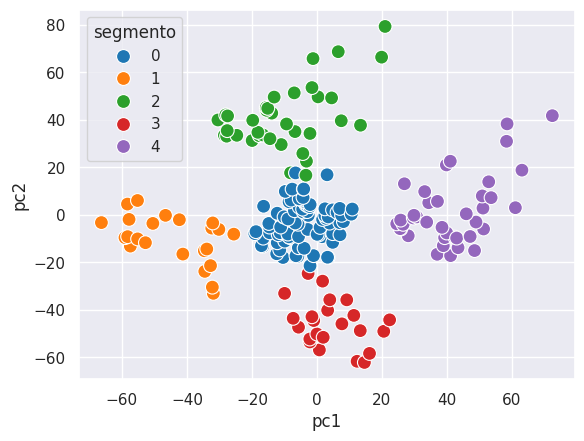

In [24]:
sns.scatterplot(
    data=pdata,
    x = 'pc1',
    y= 'pc2',
    hue= 'segmento',
    palette= paleta,
    s= 100 )
plt.show()

Cuando se reduce la data a dos dimensiones se evidencia que los grupos quedaron separados de manera aceptable.

In [25]:
data.head(5)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),segmento
0,1,Male,19,15,39,1
1,2,Male,21,15,81,3
2,3,Female,20,16,6,1
3,4,Female,23,16,77,3
4,5,Female,31,17,40,1


In [26]:
function_dictionary = {
    'Age': ['mean', 'max', 'min'],
    'Annual Income (k$)': ['mean', 'max', 'min'],
    'Spending Score (1-100)':['mean', 'max', 'min']
}

data.groupby(['segmento']).aggregate(function_dictionary)



Age         Annual Income (k$)          Spending Score (1-100)      \
          mean max min               mean  max min                   mean max   
segmento                                                                        
0        43.09  70  18              55.29   76  40                  49.57  60   
1        45.22  67  19              26.30   39  15                  20.91  40   
2        40.67  59  19              87.75  137  70                  17.58  39   
3        25.52  35  18              26.30   39  15                  78.57  99   
4        32.69  40  27              86.54  137  69                  82.13  97   

              
         min  
segmento      
0         35  
1          3  
2          1  
3         61  
4         63

**Puntuación de ingresos vs gastos anuales**
---

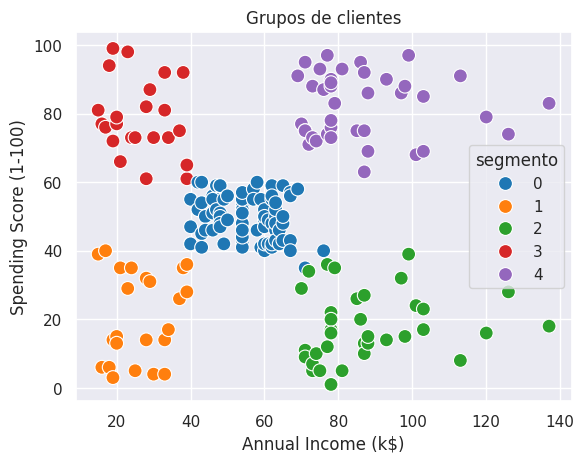

In [27]:
figsize=( 10 , 8 )
sns.scatterplot(
    data=data,
    x = 'Annual Income (k$)',
    y= 'Spending Score (1-100)',
    hue= 'segmento',
    palette= paleta,
    s= 100 )

# Agregar un título a la trama
plt.title('Grupos de clientes')

# Mostrar el gráfico
plt.show()

**Interpretando los grupos**
---

Los grupos observables brindan una diferencia entre los segmentos segun sus ingresos y habitos de gasto.

**Bajos ingresos, bajo gasto**

Representado por el segmento 1. Clientes con un ingreso anual entre 20 y 40k; y una puntuación de gasto entre 0 y 40. Tienen ingresos más bajos y tienden a gastar menos.

**Altos ingresos, bajo gasto**

Representado por el segmento 2. Clientes con ingresos anuales de aproximadamente 65k y 140k; y de gasto entre 0 y 40. Pese a tener altos ingresos, gastan menos.


**Medio bajo ingresos, medio gasto**

Representado por el segmento 0.  Clientes con un ingreso anual entre 40 y 80k y un puntaje de gasto entre 40 y 60. Estos clientes tienen ingresos y hábitos de gasto moderados. Este es el grupo más concentrado, lo que indica que una gran cantidad de clientes entran en esta categoría.


**Bajos ingresos, alto gasto**

Representado por el segmento 3. Clientes con un ingreso anual aproximado entre 20k y 40k; y un puntaje de gasto entre 60 y 100. Curiosamente, estos clientes tienen ingresos más bajos, pero tienden a gastar más. Si nos basamos en estas dos variables podrían ser clientes que tienden adquirir productos económicos.

**Altos ingresos, alto gasto**

Representado por el segmento 4. Clientes con un ingreso anual aproximado  entre 70k y 140k y un puntaje de gasto entre 60 y 100. Estos clientes tienen ingresos más altos y también tienden a gastar más, propensos a cualquier oferta.


**Segmentos de clientes según la edad y la puntuación de gasto**
---


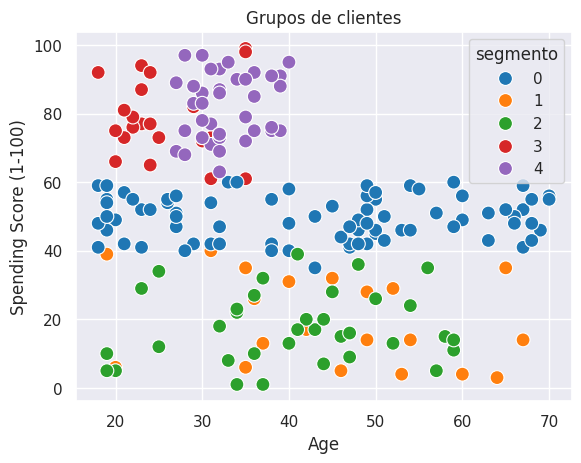

In [28]:
figsize=( 10 , 8 )
sns.scatterplot(
    data=data,
    x = 'Age',
    y= 'Spending Score (1-100)',
    hue= 'segmento',
    palette= paleta,
    s= 100 )

# Agregar un título a la trama
plt.title('Grupos de clientes')

# Mostrar el gráfico
plt.show()

**Interpretando los grupos**
---

Los grupos observables brindan una diferencia entre los segmentos segun sus edades y habitos de gasto.

Se aprecia que hay grupos distinguibles , en comparación a otros como el 0, 1 y 2.

**Jóvenes y adultos jovenes que gastan mucho**

Representados por el segmento 4 y 3. Estos grupos representan a clientes más jóvenes que tienen puntuaciones de gasto altas. Es posible que se sientan atraídos por los artículos de moda y estén dispuestos a gastar más. Estos dos grupos incluyen clientes de entre 20 y 40 años con una puntuación de gasto entre 60 y 100. El hecho de que estos grupos casi se superpongan podría sugerir que la edad es un factor menos distintivo entre estos clientes que gastan mucho.


**Personas de la mediana y tercera edad**

Representados por el segmento 1 y 2. Este grupo representa a clientes mayores que tienen puntuaciones de gasto bajas. Es posible que sean más frugales o menos atraídos por los productos ofrecidos. Es un segmento más disperso.


**Personas de diferentes edades y gasto moderado**

Representados por el segmento 0. Este grupo representa a clientes con diferentes edades con puntuaciones de gasto moderadas. Es posible que sean más conservadores en sus hábitos de gasto. Este grupo incluye edades comprendidas entre 20 y 70 años y una puntuación de gasto entre 40 y 60 años. Se trata de un rango de edad amplio, lo que sugiere que el centro comercial atrae a clientes de distintas edades que tienen una puntuación de gasto moderada. Esta podría ser la principal base de clientes del centro comercial, pese a ser disperso, es denso en el rango de edades.







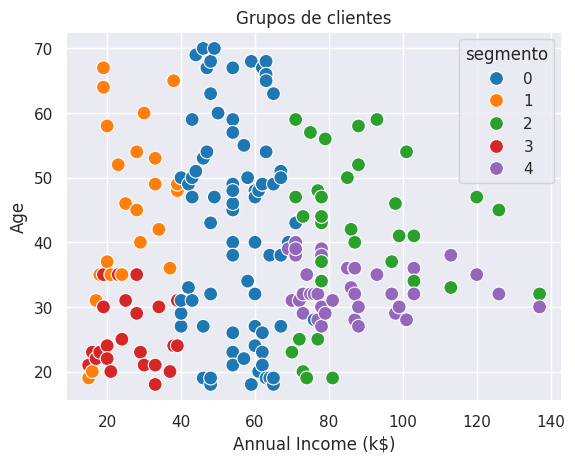

In [29]:
figsize=( 10 , 8 )
sns.scatterplot(
    data=data,
    x = 'Annual Income (k$)',
    y= 'Age',
    hue= 'segmento',
    palette= paleta,
    s= 100 )

# Agregar un título a la trama
plt.title('Grupos de clientes')

# Mostrar el gráfico
plt.show()

**Segmentos de clientes según el genero**
---

**Clientes con diferentes edades, ingresos medios**

Representado con el segmento 0. Son clientes que densamente disperso, donde se encuentran clientes desde jóvenes hasta adultos mayores, que tiene aproximadamente ingresos medios entre 40k y 65k. Podríamos suponer posiblemente la clase media.

**Jóvenes, ingresos bajos**

Representado con el segmento 3. Son clientes concentrados, donde se encuentran clientes jóvenes o adultos jóvenes entre las edades de 20 a 35, que tiene aproximadamente ingresos bajos entre 20k y 40k. Podríamos suponer posiblemente la clase baja o clientes iniciando su etapa productiva.

**Mediana y tercera edad, ingresos bajos**

Representado con el segmento 1. Son clientes concentrados, donde se encuentran clientes de la mediana y tercera edad, entre las edades de 40 a 70, que tiene aproximadamente ingresos bajos entre 20k y 40k. Podríamos suponer posiblemente la clase baja o clientes iniciando su etapa productiva.


**Adultos Jovenes, ingresos altos**

Representado con el segmento 4. Son clientes concentrados, donde se encuentran clientes adultos jovenes, entre las edades de 30 a 40, que tiene aproximadamente ingresos altos entre 80k y 140k. Podríamos suponer posiblemente la clase alta o clientes consolidados en su etapa productiva.

**Mediana y tercera edad, ingresos altos**

Representado con el segmento 2. Son clientes concentrados mayormente en edades de la mediana y tercera edad, entre las edades de 40 a 60, que tiene aproximadamente ingresos altos entre 80k y 140k. Podríamos suponer posiblemente la clase alta.

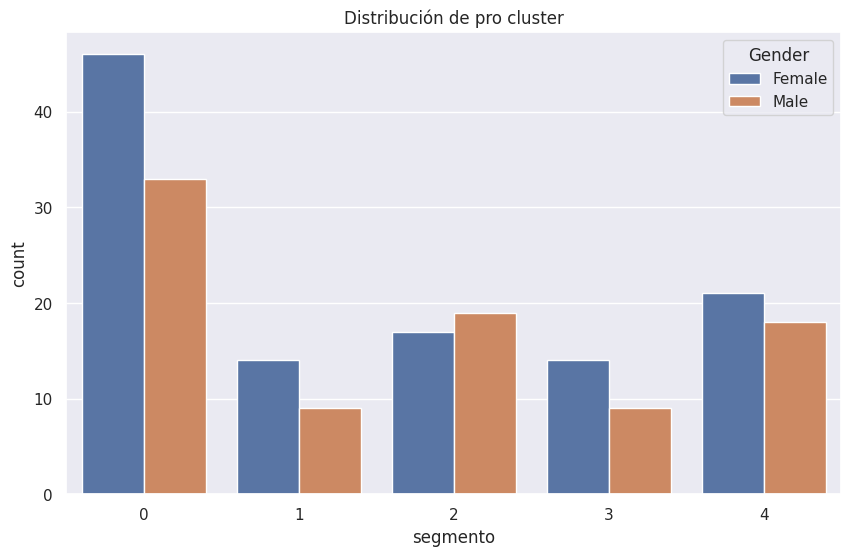

In [30]:
plt.figure(figsize=( 10 , 6 ))
sns.countplot(data=data, x= 'segmento' , hue= 'Gender' )
plt.title( 'Distribución de pro cluster' )

plt.show()

**Interpretando los grupos**
---

Los grupos generalmente exhiben una distribución de género equilibrada, con algunas desviaciones interesantes. Destaca el Clúster 0 con una proporción significativamente mayor de mujeres. Esto sugiere que las mujeres de con hábitos de gasto moderados constituyen un grupo demográfico clave para este centro comercial.

El Grupo 2 es el único donde los hombres superan ligeramente a las mujeres. Esto podría indicar diferentes hábitos de compra o preferencias entre los géneros a medida que envejecen. En todos los demás grupos, las mujeres son mayoría, lo que indica que forman una parte importante de la base de clientes del centro comercial.


**Explorando las relaciones por pares: una descripción general del diagrama de pares**
---

In [31]:
data['segmento'] = data['segmento'].astype(str)

In [32]:
p = {0: paleta[0], 1: paleta[1], 2: paleta[2], 3: paleta[3], 4: paleta[4]}

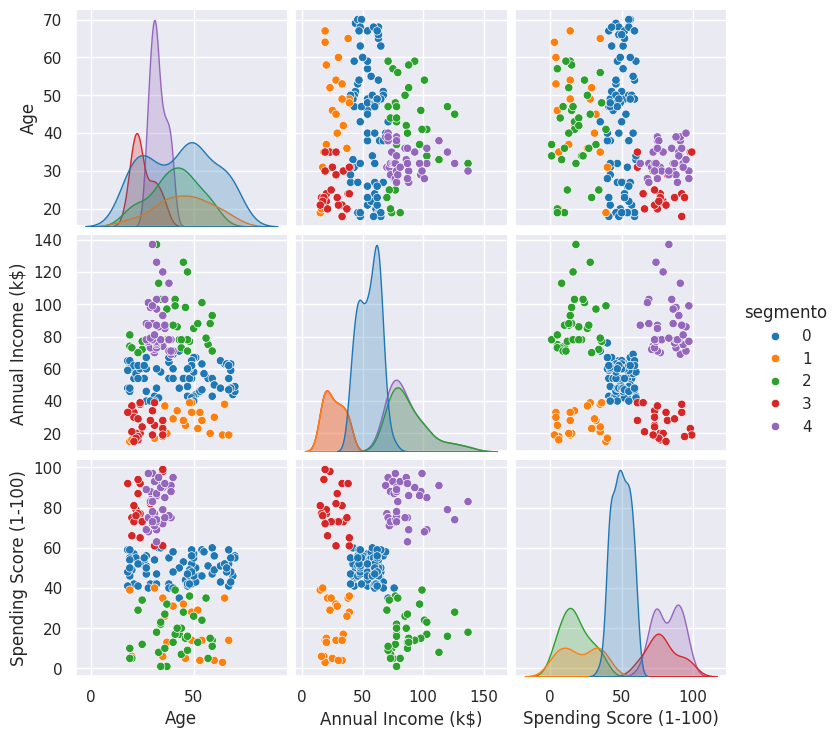

In [33]:
sns.pairplot(data.sort_values(by='segmento'), hue='segmento', palette=paleta)

**Características del conglomerado: análisis de diagrama de caja**
---


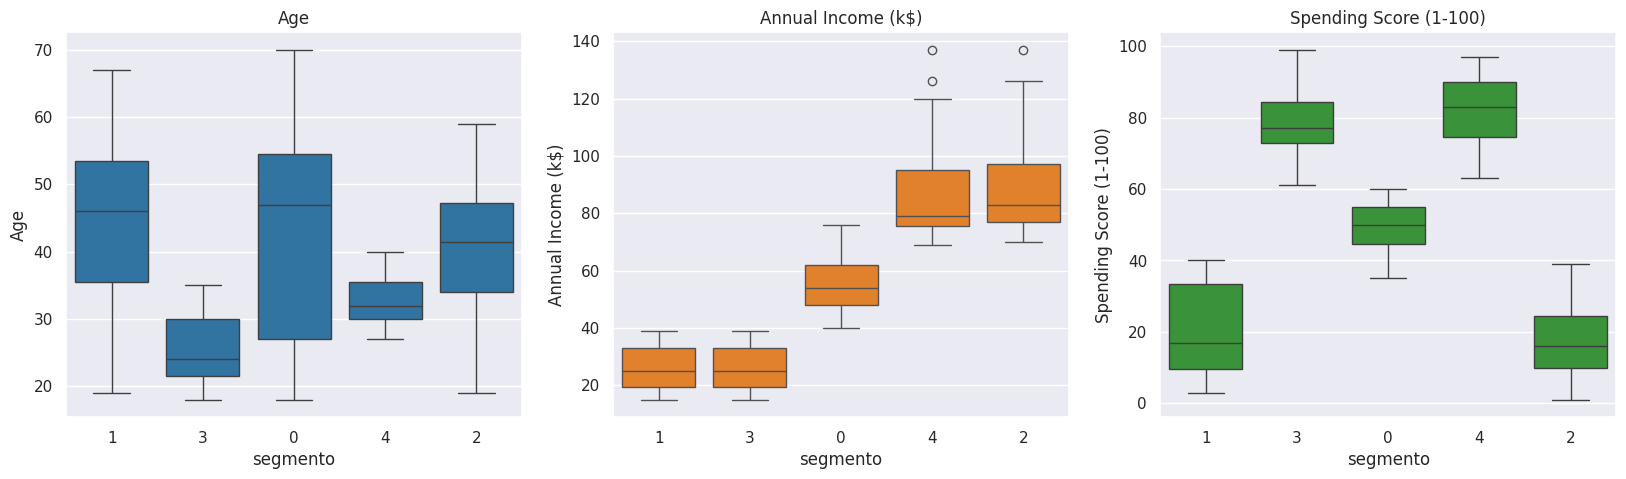

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.boxplot(data=data, x='segmento', y='Age', ax=ax[0], color=paleta[0])
ax[0].set_title('Age')

sns.boxplot(data=data, x='segmento', y='Annual Income (k$)', ax=ax[1], color=paleta[1])
ax[1].set_title('Annual Income (k$)')

sns.boxplot(data=data, x='segmento', y='Spending Score (1-100)', ax=ax[2], color=paleta[2])
ax[2].set_title('Spending Score (1-100)')

plt.show()

La edad no es que sea una variable tan significativa en la agrupación, ya que los grupos no presentan una diferencia tan significativa.


En el ingreso, se visualiza que los segmentos 1 y 3 tiene ingresos anuales entre rangos similares. El segmento 0 tiene ingresos medios. Los segmentos 4 y 2 presentan ingresos altos. Sin entrar en detalle entre las distribuciones, se puede visualizar una separación significativa.

La calificación de los gastos, deja ver que la variable permite una separación considerada. Donde los segmentos 1 y 2 tiene una calificación baja en el gasto. Los segmentos 3 y 4 tienen un score más alto. Por último el segmento cero tienen una calificación media.

**Caracterización más general**

**Clúster 0, grupo recurrente**

Clientes con ingresos medios bajos y hábitos de gastos moderados, es el grupo más denso, con un rango de edades más amplio, lo que indica una gran cantidad de clientes entran en esta categoría. Esta podría ser la base de clientes del centro comercial


**Estimación simple de significancia de variables**
---



In [35]:
X = data[['Age', 'Annual Income (k$)',	'Spending Score (1-100)']]
y = data['segmento']

In [36]:
data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),segmento
0,1,Male,19,15,39,1
1,2,Male,21,15,81,3
2,3,Female,20,16,6,1
3,4,Female,23,16,77,3
4,5,Female,31,17,40,1
...,...,...,...,...,...,...
195,196,Female,35,120,79,4
196,197,Female,45,126,28,2
197,198,Male,32,126,74,4
198,199,Male,32,137,18,2


In [37]:
model = ExtraTreesClassifier(n_estimators=100, random_state=0)
model.fit(X, y)
model.feature_importances_

array([0.15136418, 0.40631298, 0.44232284])

In [38]:
model.feature_names_in_

array(['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
      dtype=object)

In [39]:
dict(zip(model.feature_names_in_, model.feature_importances_))

pd.DataFrame({'variables': model.feature_names_in_.tolist(),
 'importancia':model.feature_importances_.tolist()}).sort_values(
    by='importancia', ascending=False)

,variables,importancia
2,Spending Score (1-100),0.44
1,Annual Income (k$),0.41
0,Age,0.15


- La edad tiene menos importancia que el resto de variables, se podría validar en otro experimento que sucede si se descarta Age. Esto puede deberse a que por sí sola no realiza una separación significativa para los segmentos.